## Window Part'n and Reversing Part'n

In [1]:
import torch
from einops import rearrange

def window_partition(x, window_size):
    B, H, W, C = x.shape
    nh, nw = H // window_size, W // window_size
    windows = rearrange(x, "b (nh ws1) (nw ws2) c -> (b nh nw) ws1 ws2 c", ws1=window_size, ws2=window_size, nh=nh, nw=nw)
    return windows

def window_reverse(windows, window_size, H, W):
    nh, nw = H // window_size, W // window_size
    x = rearrange(windows, "(n nh nw) ws1 ws2 c -> n (nh ws1) (nw ws2) c", ws1=window_size, ws2=window_size, nh=nh, nw=nw)
    return x

In [2]:
H, W = 32, 32
x = torch.rand((1, H, W, 3))
window_size = 4
windows = window_partition(x, window_size)
print(f"{windows.shape=}")
x_ = window_reverse(windows, window_size, H, W)
print(f"{x_.shape=}")

windows.shape=torch.Size([64, 4, 4, 3])
x_.shape=torch.Size([1, 32, 32, 3])


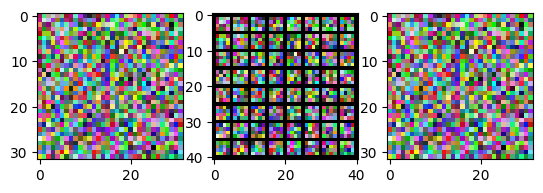

In [3]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

plt.subplot(1, 3, 1)
plt.imshow(x[0])
plt.subplot(1, 3, 2)
plot = make_grid(windows.permute(0, 3, 1, 2), padding=1).permute(1, 2, 0)
plt.imshow(plot)
plt.subplot(1, 3, 3)
plt.imshow(x_[0])

## Rel've Post'n Bias

In [16]:
window_size = 2, 2
tbl = torch.zeros((2 * window_size[0] - 1) * (2 * window_size[1] -1), 1)
print(f"{tbl.shape=}")
coords_h = torch.arange(window_size[0])
coords_w = torch.arange(window_size[1])
print(f"{coords_h=} {coords_w=}")
coords = torch.stack(torch.meshgrid([coords_h, coords_w], indexing='ij'))  # 2, Wh, Ww
print(f"{coords=}")
coords_flatten = torch.flatten(coords, 1)  # 2, Wh*Ww
print(f"{coords_flatten=}")
relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, Wh*Ww, Wh*Ww
print(f"{coords_flatten[:, :, None].shape=}")
print(f"{coords_flatten[:, None, :].shape=}")
relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # Wh*Ww, Wh*Ww, 2
print(f"{relative_coords=}")
relative_coords[:, :, 0] += window_size[0] - 1  # shift to start from 0
relative_coords[:, :, 1] += window_size[1] - 1
relative_coords[:, :, 0] *= 2 * window_size[1] - 1
relative_position_index = relative_coords.sum(-1)  # Wh*Ww, Wh*Ww
print(relative_position_index)

tbl.shape=torch.Size([9, 1])
coords_h=tensor([0, 1]) coords_w=tensor([0, 1])
coords=tensor([[[0, 0],
         [1, 1]],

        [[0, 1],
         [0, 1]]])
coords_flatten=tensor([[0, 0, 1, 1],
        [0, 1, 0, 1]])
coords_flatten[:, :, None].shape=torch.Size([2, 4, 1])
coords_flatten[:, None, :].shape=torch.Size([2, 1, 4])
relative_coords=tensor([[[ 0,  0],
         [ 0, -1],
         [-1,  0],
         [-1, -1]],

        [[ 0,  1],
         [ 0,  0],
         [-1,  1],
         [-1,  0]],

        [[ 1,  0],
         [ 1, -1],
         [ 0,  0],
         [ 0, -1]],

        [[ 1,  1],
         [ 1,  0],
         [ 0,  1],
         [ 0,  0]]])
tensor([[4, 3, 1, 0],
        [5, 4, 2, 1],
        [7, 6, 4, 3],
        [8, 7, 5, 4]])


tensor([[[0, 0, 1, 1]],

        [[0, 1, 0, 1]]])

In [6]:
""" Swin Transformer Block.

Args:
    dim (int): Number of input channels.
    input_resolution (tuple[int]): Input resulotion.
    num_heads (int): Number of attention heads.
    window_size (int): Window size.
    shift_size (int): Shift size for SW-MSA.
    mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
    qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
    qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
    drop (float, optional): Dropout rate. Default: 0.0
    attn_drop (float, optional): Attention dropout rate. Default: 0.0
    drop_path (float, optional): Stochastic depth rate. Default: 0.0
    act_layer (nn.Module, optional): Activation layer. Default: nn.GELU
    norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    fused_window_process (bool, optional): If True, use one kernel to fused window shift & window partition for acceleration, similar for the reversed part. Default: False
"""

input_resolution = 8, 8
window_size = 4
shift_size = 2

# calculate attention mask for SW-MSA
H, W = input_resolution
img_mask = torch.zeros((1, H, W, 1))  # 1 H W 1
h_slices = (slice(0, -window_size),
            slice(-window_size, -shift_size),
            slice(-shift_size, None))
w_slices = (slice(0, -window_size),
            slice(-window_size, -shift_size),
            slice(-shift_size, None))
print(f"{h_slices=}", f"{w_slices=}")
cnt = 0
for h in h_slices:
    for w in w_slices:
        img_mask[:, h, w, :] = cnt
        cnt += 1

mask_windows_ = window_partition(img_mask, window_size)  # nW, window_size, window_size, 1
mask_windows = mask_windows_.view(-1, window_size * window_size)
attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
attn_mask = attn_mask.masked_fill(attn_mask != 0, float(1.0)).masked_fill(attn_mask == 0, float(0.0))

h_slices=(slice(0, -4, None), slice(-4, -2, None), slice(-2, None, None)) w_slices=(slice(0, -4, None), slice(-4, -2, None), slice(-2, None, None))


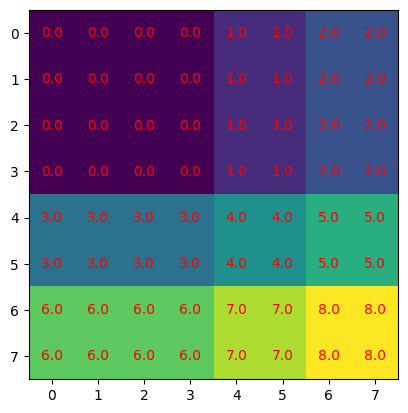

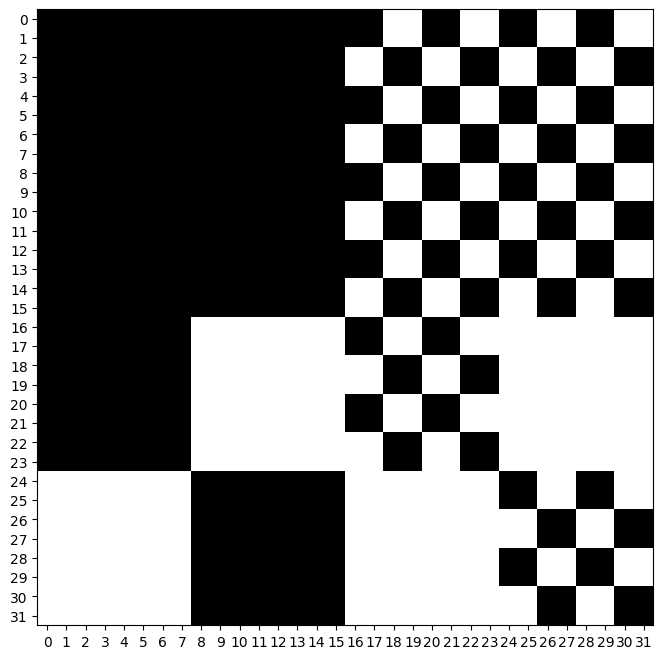

In [7]:
mask = img_mask.squeeze(-1).squeeze(0)
plt.imshow(mask)

for i in range(mask.shape[0]):
    for j in range(mask.shape[1]):
        plt.text(j, i, f"{mask[i, j]}",
                 ha="center", va="center", color="red")
plt.show()
attn_mask_img = make_grid(attn_mask.unsqueeze(1), nrow=int(attn_mask.shape[0] ** .5), padding=0)
mask = attn_mask_img.permute(1, 2, 0)
plt.figure(figsize=(8, 8))
plt.imshow(mask, cmap="gray")
H, W = mask.shape[:2]
plt.xticks(range(W))
plt.yticks(range(H))
plt.show()

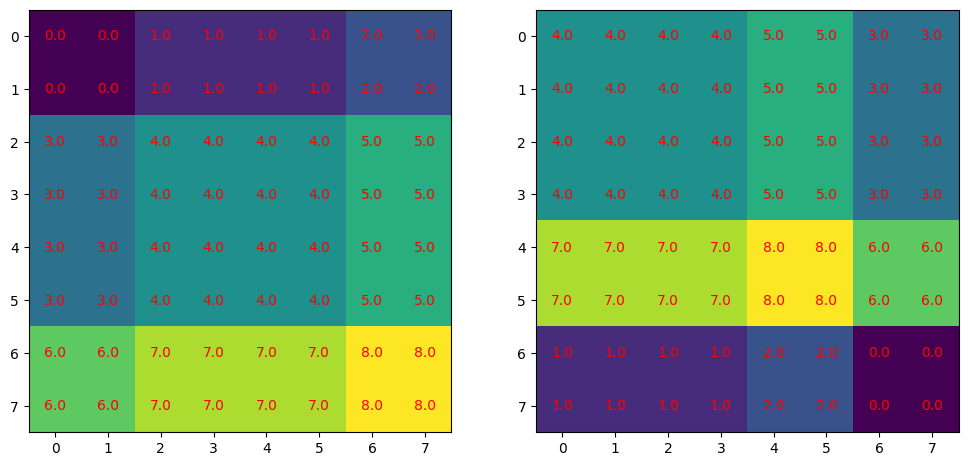

In [13]:
plt.figure(figsize=(12, 12))
plt.subplot(1,2,1)
mask = torch.zeros((8, 8))
mask[:2, 2:6] = 1.0
mask[:2, 6:] = 2.0
mask[2:6, :2] = 3.0
mask[2:6, 2:6] = 4.0
mask[2:6, 6:] = 5.0
mask[6:, :2] = 6.0
mask[6:, 2:6] = 7.0
mask[6:, 6:] = 8.0
plt.imshow(mask)
for i in range(mask.shape[0]):
    for j in range(mask.shape[1]):
        plt.text(j, i, f"{mask[i, j]}",
                 ha="center", va="center", color="red")
plt.subplot(1,2,2)
shifted_img_mask = torch.roll(mask.unsqueeze(0).unsqueeze(-1), shifts=(-shift_size, -shift_size), dims=(1,2))
mask = shifted_img_mask.squeeze(-1).squeeze(0).numpy()
plt.imshow(mask)
for i in range(mask.shape[0]):
    for j in range(mask.shape[1]):
        plt.text(j, i, f"{mask[i, j]}",
                 ha="center", va="center", color="red")
plt.show()